In [1]:
import SymbolList as sl
import pandas as pd
import datetime as dt 
import fix_yahoo_finance as yf
from statsmodels.formula.api import ols 
import seaborn as sns;  sns.set()

## 1. Symbol List 초기화 또는 불러오기

In [12]:
df = sl.init_symbol_DF()
sl.add_symbol(df,'삼성SDS','018260.Ks',init=True)
sl.add_symbol(df,'KODEX_IT','266370.Ks')
sl.add_symbol(df,'PHLX_Semiconductor','^SOX')
sl.add_symbol(df,'TIGER_200_IT','139260.KS')
sl.add_symbol(df,'BTC_USD','BTCUSD=X')
df = sl.init_symbol_DF()

DUP : 삼성SDS
DUP : Apple
DUP : Microsoft
DUP : IBM
DUP : Oracle
DUP : Amazon
DUP : Tesla
DUP : Samsung_Electronics
DUP : SK_hynix
DUP : LG_Electronics
DUP : NAVER
DUP : KODEX_IT
DUP : PHLX_Semiconductor
DUP : TIGER_200_IT
ADD : BTC_USD


In [13]:
df

,Symbol,From,To
Name,,,
삼성SDS,018260.Ks,2010-01-01,2019-05-20
Apple,AAPL,2010-01-01,2019-05-20
Microsoft,MSFT,2010-01-01,2019-05-20
IBM,IBM,2010-01-01,2019-05-20
Oracle,ORCL,2010-01-01,2019-05-20
Amazon,AMZN,2010-01-01,2019-05-20
Tesla,TSLA,2010-01-01,2019-05-20
Samsung_Electronics,005930.KS,2010-01-01,2019-05-20
SK_hynix,000660.KS,2010-01-01,2019-05-20


## 2. Symbol List 에서 데이터 받기

In [14]:
list_df = [None] * len(df.index)

TODO::이전에 받은 날짜에 이어서 붙이는거 추가하자.

In [15]:
for idx in range(0,len(df.index)):
    list_df[idx] = df.index[idx]
    print('Note::Processing  ' + list_df[idx])
    today = dt.datetime.utcnow().strftime("%Y-%m-%d")
    # 이미 최신 데이터
    if(df.iloc[idx][2] == today):
        print('  Pass::Alread up-to-date.')
        continue
    try:
        # print(start + " ~ " + today)
        temp_df = yf.download(df.iloc[idx][0], start = df.iloc[idx][1], end =  today)
        df.iloc[idx][2] = today
    except ValueError:
        print('Value Error')
    temp_df.to_csv(list_df[idx] + '.csv')
# 심볼리스트 갱신
df.to_csv('symbol_list.csv')
print('Note::symbol_list.csv is updated.')

Note::Processing  삼성SDS
  Pass::Alread up-to-date.
Note::Processing  Apple
  Pass::Alread up-to-date.
Note::Processing  Microsoft
  Pass::Alread up-to-date.
Note::Processing  IBM
  Pass::Alread up-to-date.
Note::Processing  Oracle
  Pass::Alread up-to-date.
Note::Processing  Amazon
  Pass::Alread up-to-date.
Note::Processing  Tesla
  Pass::Alread up-to-date.
Note::Processing  Samsung_Electronics
  Pass::Alread up-to-date.
Note::Processing  SK_hynix
  Pass::Alread up-to-date.
Note::Processing  LG_Electronics
  Pass::Alread up-to-date.
Note::Processing  NAVER
  Pass::Alread up-to-date.
Note::Processing  KODEX_IT
  Pass::Alread up-to-date.
Note::Processing  PHLX_Semiconductor
  Pass::Alread up-to-date.
Note::Processing  TIGER_200_IT
  Pass::Alread up-to-date.
Note::Processing  BTC-USD
  Pass::Alread up-to-date.
Note::Processing  BTC_USD
[*********************100%***********************]  1 of 1 downloaded
Note::symbol_list.csv is updated.


## 3. 통계

+ how to calculate coskew and cokurtosis
https://stackoverflow.com/questions/41890870/how-to-calculate-coskew-and-cokurtosis

생각을 좀 해봐야겠다.

$$ K(X,X,Y,Y)= {E[(X - E[X])^2(Y - E[Y]^2)] \over \sigma_X^2\sigma_Y^2}$$

In [16]:
t_df = pd.read_csv(list_df[0] + '.csv',index_col = 'Date')

# 연간 종가
t_data = t_df.iloc[-240:]['Close']
t_data.kurt()

-1.0235350210514458

### 2개 지수 비교

In [23]:
target_1 = 'Samsung_Electronics'
target_2 = 'BTC_USD'

In [24]:
ols_df1 = pd.read_csv(target_1 + '.csv',index_col='Date')
ols_df1 = ols_df1[['Close']]
ols_df1.columns = [target_1]
ols_df1.head()

,Samsung_Electronics
Date,
2010-01-04,16180.0
2010-01-05,16440.0
2010-01-06,16820.0
2010-01-07,16260.0
2010-01-08,16420.0


In [19]:
ols_df2 = pd.read_csv(target_2 + '.csv',index_col='Date')
ols_df2 = ols_df2[['Close']]
ols_df2.columns = [target_2]
ols_df2.head()

,BTC-USD
Date,
2010-07-18,0.08080
2010-07-19,0.07474
2010-07-20,0.07921
2010-07-21,0.05050
2010-07-22,0.06262


In [20]:
new_df = pd.concat([ols_df1, ols_df2], axis=1, sort=False)
new_df = new_df.dropna()
new_df = new_df[-240:]
new_df.head()

,Samsung_Electronics,BTC-USD
2017-12-26,48200.0,15756.566406
2017-12-27,49360.0,15416.633789
2017-12-28,50960.0,14398.702148
2018-01-02,51020.0,14754.137695
2018-01-03,51620.0,15156.613281


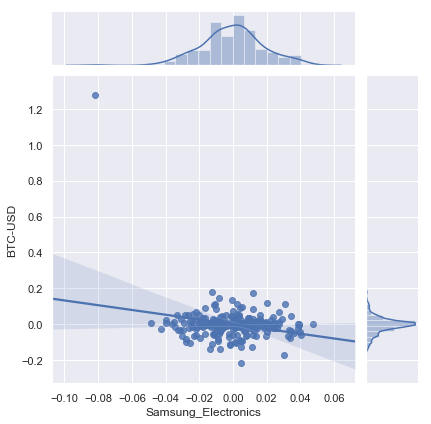

In [21]:
ret_index = new_df.pct_change()
ret_index = ret_index.dropna()
sns.jointplot(target_1, target_2, data = ret_index, kind='reg')

In [22]:
model_fit = ols(target_1+'~'+target_2, data=ret_index).fit()
print(model_fit.summary())

PatsyError: Error evaluating factor: NameError: name 'BTC' is not defined
    Samsung_Electronics~BTC-USD
                        ^^^